In [1]:
#pip install networkx

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# Step 1: Creating a Simple Transport Network of 4 Zones

We start by importing the necessary libraries:

- `networkx as nx` for creating and working with graphs (networks)  
- `matplotlib.pyplot as plt` for graph visualization

Then we create an empty undirected graph `G` using:

```python
G = nx.Graph()
```

A **graph** is a structure made of **nodes** and **edges**.  
In a transportation model:

- **Nodes** represent zones  
- **Edges** represent roads connecting these zones

We define a list of 4 zones labeled as 1, 2, 3, and 4, and add them as nodes to the graph `G`.

Next, we define a list of edges — pairs of zones that are connected by roads, e.g., `(1, 2)` represents a road between zones 1 and 2. These edges are added to the graph.

We also define positions for each node to place them on a 2D plane for visualization purposes.  
For example, zone 1 is placed at `(0, 1)` and zone 4 at `(1, 0)`.  
This helps layout the graph in a square shape for clarity.

**Summary:**

- A simple graph with 4 nodes (zones)  
- Connectivity between zones using edges (roads)  
- Clear visualization of the network structure

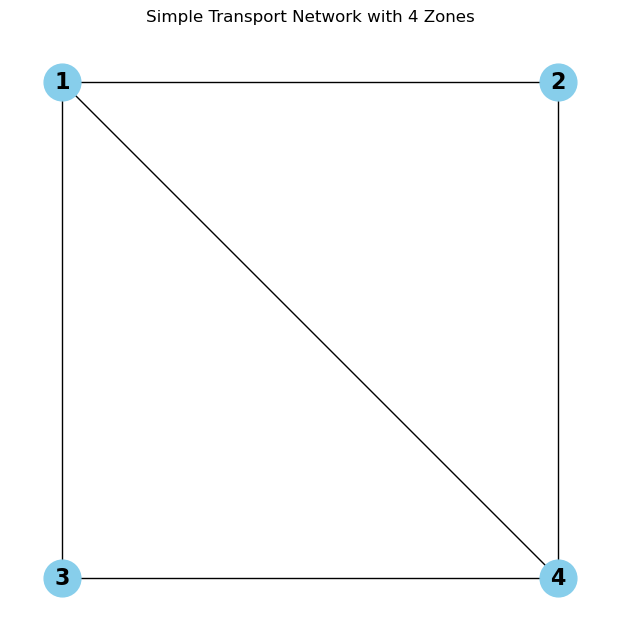

In [3]:
# Create the graph
G = nx.Graph()

# Add nodes (4 zones)
zones = [1, 2, 3, 4]
G.add_nodes_from(zones)

# Add edges (roads between zones)
edges = [
    (1, 2),  # road between zone 1 and 2
    (1, 3),  # road between zone 1 and 3
    (2, 4),  # road between zone 2 and 4
    (3, 4),  # road between zone 3 and 4
    (1, 4),  # diagonal road between zone 1 и 4
]

G.add_edges_from(edges)

# Set node positions for visualization
pos = {
    1: (0, 1),
    2: (1, 1),
    3: (0, 0),
    4: (1, 0),
}

# Visualize the graph
plt.figure(figsize=(6,6))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=16, font_weight='bold')
plt.title("Simple Transport Network with 4 Zones")
plt.show()

# Step 2: Creating the OD Matrix
- Rows: Origin zones
- Columns: Destination zones
- Values: Trip Demand (Number of trips from one zone to another)

In [4]:
zones = [1, 2, 3, 4]
data = {
    1: [0, 8, 5, 3],
    2: [10, 0, 12, 7],
    3: [15, 7, 0, 9],
    4: [5, 10, 8, 0]
}

# Creating a DataFrame
od_matrix = pd.DataFrame(data, index=zones)
print(od_matrix)

   1   2   3   4
1  0  10  15   5
2  8   0   7  10
3  5  12   0   8
4  3   7   9   0


In [5]:
type(od_matrix)

pandas.core.frame.DataFrame

# Step 3: Routing and Flow Distribution

**Requirements**:
- Determine paths for traffic flows between zones, considering the transportation network structure (our graph).
- Distribute trip volumes from the OD matrix across graph edges, obtaining traffic flow for each road.

**Action Plan**:
1. For each (origin (i), destination (j)) pair in the OD matrix, find the shortest path through the graph.
2. Distribute the corresponding number of trips across the edges that comprise this path.
3. Aggregate flows from all pairs to obtain total flow for each road. (Calculate cumulative flows for each edge)

In [6]:
G.edges()

EdgeView([(1, 2), (1, 3), (1, 4), (2, 4), (3, 4)])

In [7]:
list(G.edges(data=True))

[(1, 2, {}), (1, 3, {}), (1, 4, {}), (2, 4, {}), (3, 4, {})]

In [8]:
# Creating Edge Flow Dictionary
edge_flows = {tuple(sorted(edge)): 0 for edge in G.edges()}

# Iterate through all zone pairs in the OD matrix
for origin in od_matrix.index:
    for destination in od_matrix.columns:
        if origin == destination:
            continue
        
        trips = od_matrix.loc[origin, destination]
        if trips == 0:
            continue
        
        # Find shortest path in graph
        path = nx.shortest_path(G, source=origin, target=destination)
        
        # Update flows for each edge in the path
        for i in range(len(path) - 1):
            edge = tuple(sorted((path[i], path[i + 1])))
            edge_flows[edge] += trips

# Display results
print("Modelled flows by edge:")
for edge, flow in edge_flows.items():
    print(f"{edge}: {flow}")

Modelled flows by edge:
(1, 2): 37
(1, 3): 39
(1, 4): 8
(2, 4): 17
(3, 4): 17


In [9]:
modelled_flows = edge_flows

In [10]:
edge_flows

{(1, 2): 37, (1, 3): 39, (1, 4): 8, (2, 4): 17, (3, 4): 17}

In [11]:
od_matrix.index

Index([1, 2, 3, 4], dtype='int64')

In [12]:
od_matrix.columns

Index([1, 2, 3, 4], dtype='int64')

In [13]:
od_matrix.at[origin, destination]

0

In [14]:
trips

9

**Output**: Modeled traffic flow for each road segment (model results based on OD matrix and shortest path assignment)

**Key Characteristics**:
- Generated through network assignment modeling
- Represents predicted traffic volumes
- Derived from:
  - Origin-Destination demand matrix
  - Shortest path routing algorithm
  - Graph network topology

# Step 4: Observed Flows (Synthetic Data - Simulating Real Measurements)

**Objective**:  
Create synthetic observed flow data that slightly differs from modeled flows to demonstrate calibration.

In [15]:
observed_flows = {
    (1, 2): 42,
    (1, 3): 36,
    (1, 4): 10,
    (2, 4): 20,
    (3, 4): 15
}

# Step 5: Accuracy Assessment (Pre-Calibration)

**Objective**:  
Quantify the difference between modeled and observed flows using standard error metrics.

In [16]:
# Convert Flow Data to Lists
model_values = []
observed_values = []

for edge in observed_flows:
    model_values.append(modelled_flows.get(edge, 0))
    observed_values.append(observed_flows[edge])

# Metrics
mae = mean_absolute_error(observed_values, model_values)
rmse = root_mean_squared_error(observed_values, model_values)
mape = np.mean(np.abs((np.array(observed_values) - np.array(model_values)) / np.array(observed_values))) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 3.00
RMSE: 3.19
MAPE: 13.71%


## Visualization

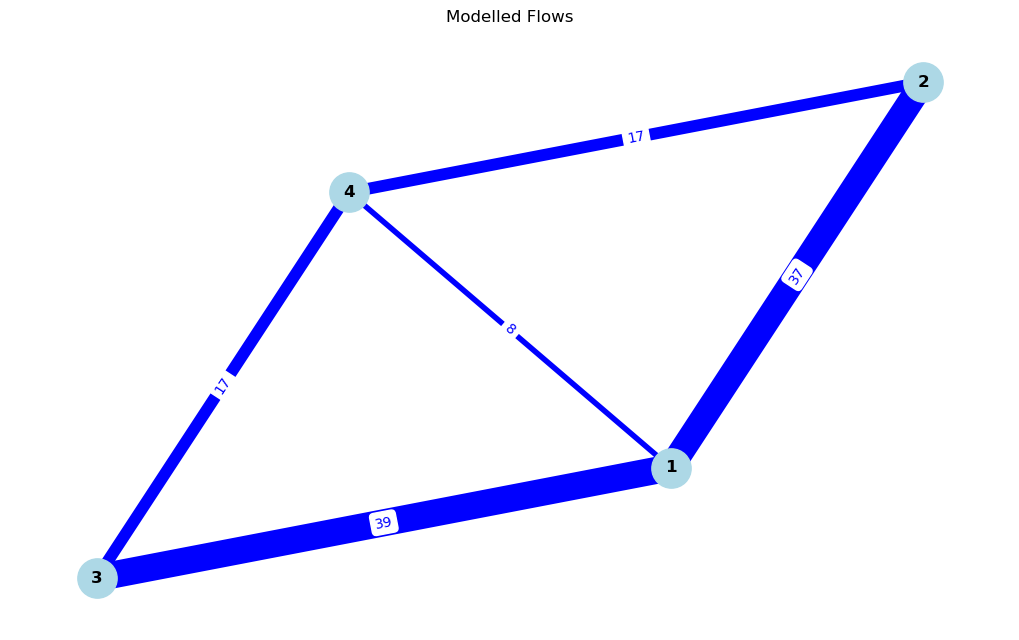

In [17]:
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=800, node_color='lightblue', font_weight='bold')

# Draw Graph with Edge Widths Proportional to Flow
edge_weights = [edge_flows[tuple(sorted(edge))] for edge in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w / 2 for w in edge_weights], edge_color='blue')

# Create edge labels dictionary
edge_labels = {edge: edge_flows[tuple(sorted(edge))] for edge in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')

plt.title('Modelled Flows')
plt.axis('off')
plt.show()

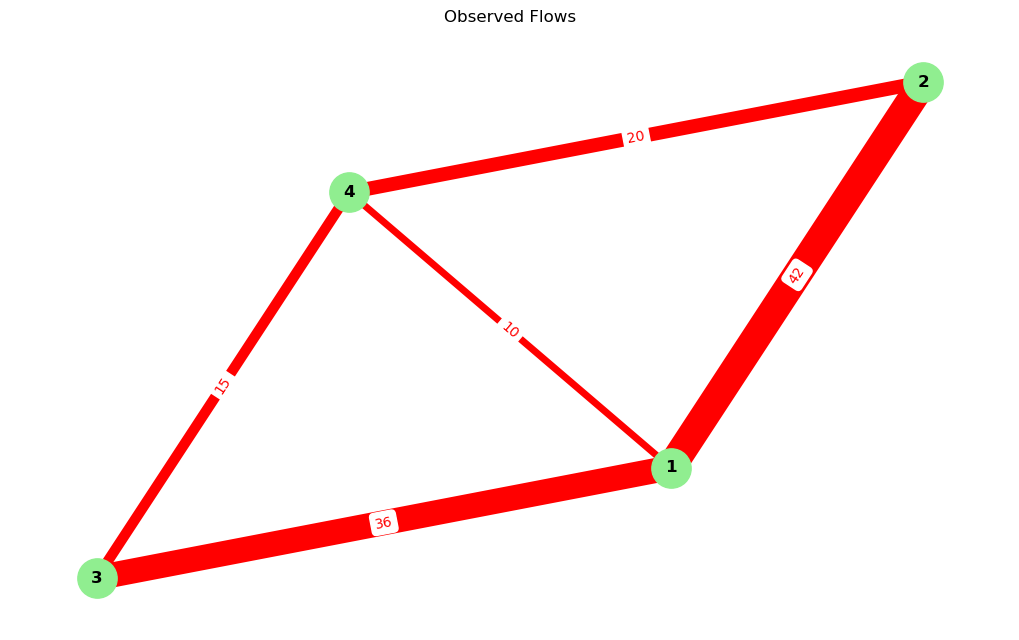

In [18]:
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=800, node_color='lightgreen', font_weight='bold')

# Edge width observed flows
obs_weights = [observed_flows[tuple(sorted(edge))] for edge in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w / 2 for w in obs_weights], edge_color='red')

# Labels
obs_labels = {edge: observed_flows[tuple(sorted(edge))] for edge in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=obs_labels, font_color='red')

plt.title('Observed Flows')
plt.axis('off')
plt.show()

# Step 6. OD Matrix Calibration

We have:
- `OD-matrix` - current demand model (trips between zones)
- `modelled_flows` - routing results based on the OD-matrix
- `observed_flows` - "real" road measurement data
- Error metrics (MAPE/MAE/RMSE) showing how much the model differs from reality

Now we need to adjust the OD-matrix to improve the match between modelled and observed flows.

How to do this?
- We'll scale rows/columns of the OD-matrix so that resulting road flows better match the real ones (`observed_flows`). For now we'll do calibration manually.

Goal: reduce the difference between `modelled_flows` and `observed_flows`. (Manually adjust OD-matrix values so that modelled flows better match observed ones).

In [19]:
modelled_flows

{(1, 2): 37, (1, 3): 39, (1, 4): 8, (2, 4): 17, (3, 4): 17}

In [20]:
observed_flows

{(1, 2): 42, (1, 3): 36, (1, 4): 10, (2, 4): 20, (3, 4): 15}

In [21]:
modelled_flows = {
    (1, 2): 40,
    (1, 3): 37,
    (1, 4): 10,
    (2, 4): 19,
    (3, 4): 16
}

observed_flows = {
    (1, 2): 42,
    (1, 3): 36,
    (1, 4): 10,
    (2, 4): 20,
    (3, 4): 15
}

# DataFrame
comparison_df = pd.DataFrame({
    "Edge": list(modelled_flows.keys()),
    "Modelled": [modelled_flows[edge] for edge in modelled_flows],
    "Observed": [observed_flows[edge] for edge in modelled_flows],
})

# Add column
comparison_df["Difference"] = comparison_df["Modelled"] - comparison_df["Observed"]


print(comparison_df)

     Edge  Modelled  Observed  Difference
0  (1, 2)        40        42          -2
1  (1, 3)        37        36           1
2  (1, 4)        10        10           0
3  (2, 4)        19        20          -1
4  (3, 4)        16        15           1


## Manual OD Matrix Adjustments

Current status:  
**Moderate errors detected** - applying targeted corrections:

Increase flow (1,2) by 3 trips
Decrease flow (1,3) by 2 trips
Increase flow (1,4) by 2 trips
Increase flow (2,4) by 2 trips
Decrease flow (3,4) by 1 trip

In [22]:
zones = [1, 2, 3, 4]
data = {
    1: [0, 11, 3, 5],
    2: [10, 0, 12, 9],
    3: [15, 7, 0, 8],
    4: [5, 10, 8, 0]
}
od_matrix = pd.DataFrame(data, index=zones)

# Creating Edge Flow Dictionary
edge_flows = {tuple(sorted(edge)): 0 for edge in G.edges()}

# Iterate through all zone pairs in the OD matrix
for origin in od_matrix.index:
    for destination in od_matrix.columns:
        if origin == destination:
            continue
        
        trips = od_matrix.loc[origin, destination]
        if trips == 0:
            continue
        
        # Shortest path
        path = nx.shortest_path(G, source=origin, target=destination)
        
        # Update flows for each edge in the path
        for i in range(len(path) - 1):
            edge = tuple(sorted((path[i], path[i + 1])))
            edge_flows[edge] += trips

modelled_flows = edge_flows

model_values = []
observed_values = []

for edge in observed_flows:
    model_values.append(modelled_flows.get(edge, 0))
    observed_values.append(observed_flows[edge])

# Metrics
final_mae = mean_absolute_error(observed_values, model_values)
final_rmse = root_mean_squared_error(observed_values, model_values)
final_mape = np.mean(np.abs((np.array(observed_values) - np.array(model_values)) / np.array(observed_values))) * 100

print(f"MAE: {final_mae:.2f}")
print(f"RMSE: {final_rmse:.2f}")
print(f"MAPE: {final_mape:.2f}%")



MAE: 1.00
RMSE: 1.18
MAPE: 3.84%


In [23]:
# Final Metrics Comparison
print(f"""
Pre-calibration  | Post-calibration
-----------------|-----------------
MAE:  {mae:.1f}    | MAE:  {final_mae:.1f}
RMSE: {rmse:.1f}   | RMSE: {final_rmse:.1f} 
MAPE: {mape:.1f}%  | MAPE: {final_mape:.1f}%
""")


Pre-calibration  | Post-calibration
-----------------|-----------------
MAE:  3.0    | MAE:  1.0
RMSE: 3.2   | RMSE: 1.2 
MAPE: 13.7%  | MAPE: 3.8%



# Project Conclusion: Successful Model Calibration

**Improved Accuracy Metrics** - The manual calibration process has yielded significant improvements:
- MAE reduced by 3 times (from 3.0 to 1.0),
- RMSE - reduced from 3.2 to 1.2,
- MAPE decreased by **9.9%** (from 13.7 to 3.8)

**Potential Enhancements:**
- Mode choice.
- Dynamic traffic assignment.
- Public transit routes.
- Gradient-based optimization.
- Machine learning calibration.